Following https://www.geeksforgeeks.org/image-segmentation-with-watershed-algorithm-opencv-python/

In [2]:
import cv2
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt
import os
import skimage as ski

In [3]:
# Plot the image
def imshow(img, ax=None):
    if ax is None:
        ret, encoded = cv2.imencode(".png", img)
        display(Image(encoded))
    else:
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')

In [130]:
original_img = ski.io.imread("/nfs/research/birney/users/esther/medaka-img/src_files/original-img-gentle-breeze-45-epoch700.png")
# reconstructed_img = ski.io.imread("/nfs/research/birney/users/esther/medaka-img/src_files/validation-img-gentle-breeze-45-epoch700.png")
reconstructed_img = ski.io.imread("/nfs/research/birney/users/esther/medaka-img/src_files/validation-img-amber-sweep-1-epoch500.png")

img = reconstructed_img

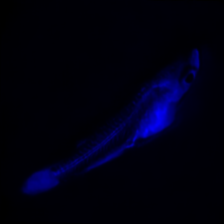

In [131]:
imshow(img)

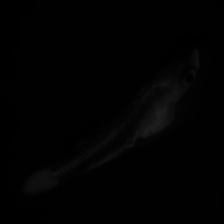

In [132]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(gray)

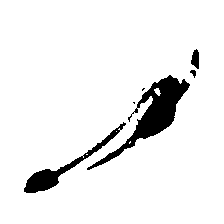

In [133]:
#Threshold Processing
ret, bin_img = cv2.threshold(gray,
                             0, 255, 
                             cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
imshow(bin_img)

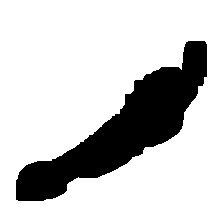

In [134]:
kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(bin_img,kernel,iterations = 4)

imshow(erosion)

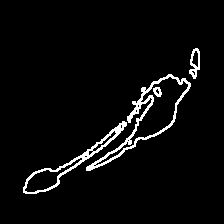

In [135]:
# noise removal
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
bin_img = cv2.morphologyEx(bin_img, 
                           cv2.MORPH_GRADIENT,
                           kernel,
                           iterations=1)
# bin_img = cv2.dilate(bin_img, kernel, iterations=1)
imshow(bin_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


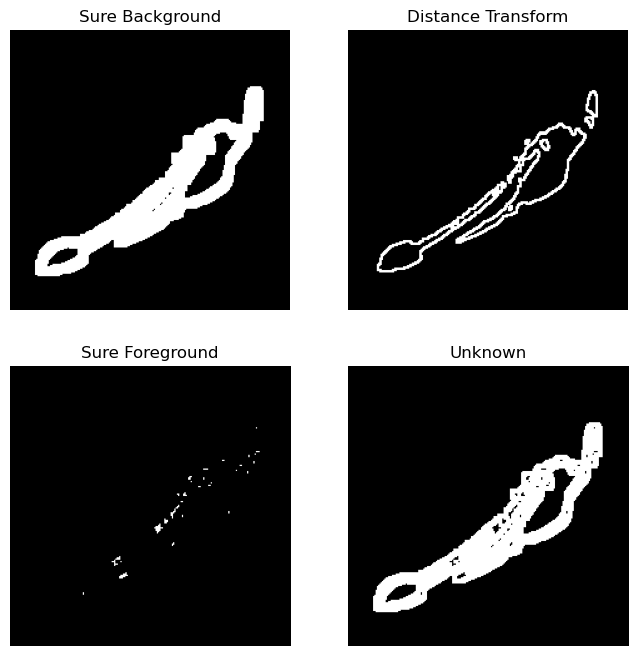

In [136]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
# sure background area
sure_bg = cv2.dilate(bin_img, kernel, iterations=3)
imshow(sure_bg, axes[0,0])
axes[0, 0].set_title('Sure Background')
 
# Distance transform
dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
imshow(dist, axes[0,1])
axes[0, 1].set_title('Distance Transform')
 
#foreground area
ret, sure_fg = cv2.threshold(dist, 0.4 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)  
imshow(sure_fg, axes[1,0])
axes[1, 0].set_title('Sure Foreground')
 
# unknown area
unknown = cv2.subtract(sure_bg, sure_fg)
imshow(unknown, axes[1,1])
axes[1, 1].set_title('Unknown')
 
plt.show()

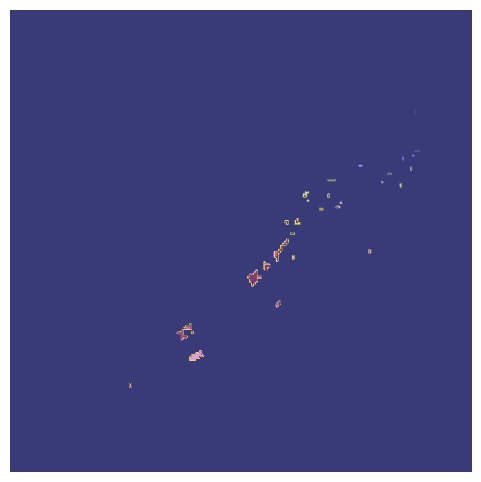

In [137]:
# Marker labelling
# sure foreground 
ret, markers = cv2.connectedComponents(sure_fg)
 
# Add one to all labels so that background is not 0, but 1
markers += 1
# mark the region of unknown with zero
markers[unknown == 255] = 0
 
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()

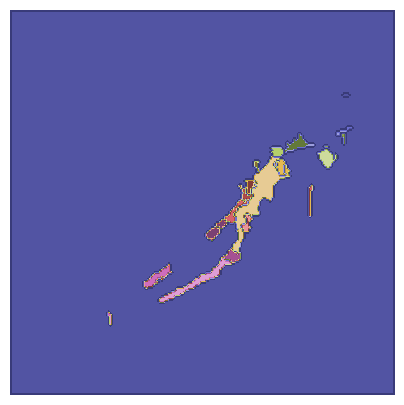

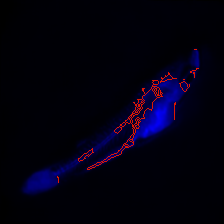

In [138]:
# watershed Algorithm
markers = cv2.watershed(img, markers)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()


labels = np.unique(markers)

coins = []
for label in labels[2:]: 

# Create a binary image in which only the area of the label is in the foreground 
#and the rest of the image is in the background 
	target = np.where(markers == label, 255, 0).astype(np.uint8)

# Perform contour extraction on the created binary image
	contours, hierarchy = cv2.findContours(
		target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
	)
	coins.append(contours[0])

# Draw the outline
img = cv2.drawContours(img, coins, -1, color=(0, 23, 223), thickness=1)
imshow(img)

In [139]:
print(markers)

[[-1 -1 -1 ... -1 -1 -1]
 [-1  1  1 ...  1  1 -1]
 [-1  1  1 ...  1  1 -1]
 ...
 [-1  1  1 ...  1  1 -1]
 [-1  1  1 ...  1  1 -1]
 [-1 -1 -1 ... -1 -1 -1]]
